# Two-Way ANOVA

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import ptitprince as pt
import matplotlib.pyplot as plt
import statistics
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import skew, kurtosis
from IPython.display import display, HTML
pd.options.display.float_format = '{:.3f}'.format

import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [105]:
#CLEANING
df = pd.read_csv("Political Interest.csv")
df = df.rename(columns={'gender': 'Gender','education_level': 'Education_Level', 'political_interest':'Political_Interest'})
df['Gender'] = df['Gender'].map({1: 'Male', 2: 'Female'})
df['Education_Level'] = df['Education_Level'].map({1: 'School', 2: 'College', 3:'University'})
df.head()

,Gender,Education_Level,Political_Interest
0,Male,School,38.000
1,Male,School,39.000
2,Male,School,35.000
3,Male,School,38.000
4,Male,School,41.000


## Dataset and Problem
The dataset contains 58 observations and a dependent variable political interest and two independent variables, educational level and gender. The gender is a categorical variable with two possible values male and female. The educational level is a categorical variable with three possible values, school, college, and university. The political interest variable is a continuous variable that indicates the individual’s level of interest in politics. 

A two-way ANOVA will be used to determine whether there is an interaction effect between two independent variables (educational level and gender) on a continuous dependent variable (political interest).

## Hypotheses
\$ H_0 \$: There is no significant interaction effect on political interest between gender and education level. \
\$ H_A \$: There is a significant interaction effect on political interest between gender and education level.

## Assumptions
### Assumption 1: You have one dependent variable that is measured at the continuous level.
**Remark:** The dependent variable *political interest* is measured at the continuous level.

### Assumption 2: You have two independent variables where each independent variable consists of two or more categorical, independent groups
**Remark:** The independent variables, *gender* and *educational level*, are categorical variables. *Gender* has two independent groups (Male and Female) and *educational level* has three independent groups (School, College, and University). 

### Assumption 3: You should have independence of observations.
**Remark:** Each case in the dataset is independent with each other as there is no relationship between the cases in each group nor between the groups themselves.

### Assumption 4: There should be no significant outliers in any cell of the design.


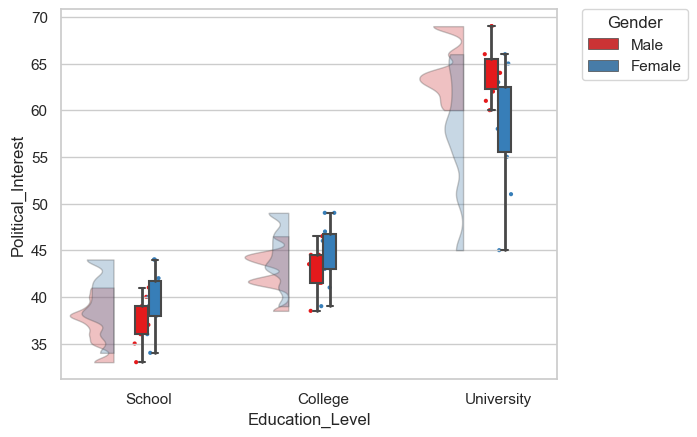

In [45]:
pt.RainCloud(data=df, x='Education_Level', y='Political_Interest', hue='Gender',
             width_viol=0.5, alpha=0.3, palette='Set1', dodge=True)

plt.show()

**Remark:** By visual inspection of the boxplots, there are no significant outliers in any group.

### Assumption 5: The distribution of the dependent variable (residuals) should be approximately normally distributed in every cell of the design.

In [48]:
df_grouped = df.groupby(['Gender', 'Education_Level'])['Political_Interest']
desc = df_grouped.agg(Valid = 'count', Mean = 'mean', SD = 'std', Min = 'min', Max = 'max', Skewness = 'skew')
skew_error = lambda x: np.sqrt((6 * len(x) * (len(x)-1))/((len(x)-2) * (len(x)+1) * (len(x)+3)))
skew_stderror = df_grouped.apply(skew_error)
skew_stderror = skew_stderror.to_frame(name='Std. Error of Skewness')
kurt_lambda = lambda x: x.kurtosis()
kurtosis = df_grouped.apply(kurt_lambda)
kurtosis= kurtosis.to_frame(name='Kurtosis')
kurt_error = lambda x: np.sqrt((24 * len(x) * (len(x) - 1) * (len(x) - 1)) / ((len(x) - 3) * (len(x) - 2) * (len(x) + 3) * (len(x) +5)))
kurt_stderror = df_grouped.apply(kurt_error)
kurt_stderror = kurt_stderror.to_frame(name='Std. Error of Kurtosis')
results = {}
for (gender, education), group in df_grouped:
    stat, p_value = shapiro(group)
    results[(gender, education)] = (stat, p_value)

shapiro = pd.DataFrame(results).transpose().rename(columns={0:'Shapiro', 1:'p-value'})
table_df = pd.concat([desc,skew_stderror, kurtosis, kurt_stderror, shapiro], axis=1)
table_df


Valid   Mean    SD    Min    Max  Skewness  \
Female College        10 44.600 3.273 39.000 49.000    -0.173   
       School         10 39.600 3.273 34.000 44.000    -0.173   
       University     10 58.000 6.464 45.000 66.000    -0.802   
Male   College         9 42.944 2.338 38.500 46.500    -0.514   
       School          9 37.444 2.506 33.000 41.000    -0.406   
       University     10 64.100 3.071 60.000 69.000     0.630   

                   Std. Error of Skewness  Kurtosis  Std. Error of Kurtosis  \
Female College                      0.687    -0.627                   1.334   
       School                       0.687    -0.627                   1.334   
       University                   0.687     0.443                   1.334   
Male   College                      0.717     0.563                   1.400   
       School                       0.717    -0.230                   1.400   
       University                   0.687    -0.505                   1.334   

                   Shapiro  p-value  
Female College       0.963    0.819  
       School        0.963    0.819  
       University    0.950    0.668  
Male   College       0.957    0.761  
       School        0.981    0.971  
       University    0.915    0.320

**Remark:** As assessed by Shapiro-Wilk's test for normality, the distribution is normal (p>0.05) for every cell in the design.

### Assumption 6: The variance of the dependent variable (residuals) should be equal in every cell of the design.

In [46]:
groups = []
for edu_level in df['Education_Level'].unique():
    for gender in df['Gender'].unique():
        group_data = df[(df['Education_Level'] == edu_level) & (df['Gender'] == gender)]['Political_Interest']
        groups.append(group_data)

stat_levene, p_levene = levene(*groups)

levene_df = pd.DataFrame({
    'F': [stat_levene],
    'df1': [len(df['Education_Level'].unique()) * len(df['Gender'].unique()) - 1],
    'df2': [len(df) - len(df['Education_Level'].unique()) * len(df['Gender'].unique())],
    'p': [p_levene]
})

levene_df['F'] = levene_df['F'].round(3)
levene_df['p'] = levene_df['p'].round(3)

title_levene = '<h4 style="text-align: left;">Test for Equality of Variances (Levene\'s Test)</h4>'
display(HTML(title_levene))
display(levene_df.style.hide(axis="index"))

F,df1,df2,p
2.205000,5,52,0.068000


**Remark:** Since \$ p = 0.068 > 0.05 \$ by the Levene's test, then the variances for each combination of the groups of gender and educational level are homogeneous.

## Computation

#### Welch's ANOVA

In [40]:
welch_model = ols('Political_Interest ~ Education_Level', data=df).fit()
welch_results = anova_lm(welch_model, typ=2)

welch_results

,sum_sq,df,F,PR(>F)
Education_Level,5424.955,2.000,154.009,0.000
Residual,968.687,55.000,NaN,NaN


**Remark:** Since p < 0.005, then there is a significant difference in the political interest per educational level.

In [87]:
anova =pg.anova(dv='Political_Interest', between = ['Gender', 'Education_Level'], data=df)
anova = anova.replace(['Residual', np.nan], ['Error', ''])
display(HTML("""<h5>Two-Way ANOVA</h5>"""), anova)

,Source,SS,DF,MS,F,p-unc,np2
0,Gender,10.705,1.000,10.705,0.745,0.392,0.014
1,Education_Level,5409.959,2.000,2704.979,188.136,0.000,0.879
2,Gender * Education_Level,210.338,2.000,105.169,7.315,0.002,0.220
3,Error,747.644,52.000,14.378,,,


**Remark:** A statistically significant interaction was found between gender and education level on interest in politics, F(2, 52) = 7.315, p = .002, partial η²p = .220. As a result, reporting the main effects of each independent variable is not appropriate, as they would be biased. Therefore, an analysis of the simple main effects for gender and education level will be conducted, with statistical significance determined using a Bonferroni adjustment and considered significant at the p < .025 level.

## Results of Simple Main Effects

### Simple Main Effects - gender

In [122]:
results = {}

alpha_adjusted = 0.025

for level in df['Education_Level'].unique():
    df_level = df[df['Education_Level'] == level]
    
    model = ols('Political_Interest ~ C(Gender)', data=df_level).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    F_value = anova_table.loc['C(Gender)', 'F']
    p_value = anova_table.loc['C(Gender)', 'PR(>F)']
    
    significant = p_value < alpha_adjusted
    
    results[level] = {'Sum of Squares': anova_table.loc['C(Gender)', 'sum_sq'],
                      'df': int(anova_table.loc['C(Gender)', 'df']),
                      'Mean Square': anova_table.loc['C(Gender)', 'sum_sq'] / anova_table.loc['C(Gender)', 'df'],
                      'F': F_value,
                      'p': p_value,
                      'Significant': significant}

results_df = pd.DataFrame(results).T
title_simpgen = '<h4 style="text-align: left;">Simple Main Effects - gender</h4>'
display(HTML(title_simpgen))
results_df

,Sum of Squares,df,Mean Square,F,p,Significant
School,22.009,1,22.009,2.552,0.129,False
College,12.983,1,12.983,1.575,0.226,False
University,186.050,1,186.050,7.266,0.015,True


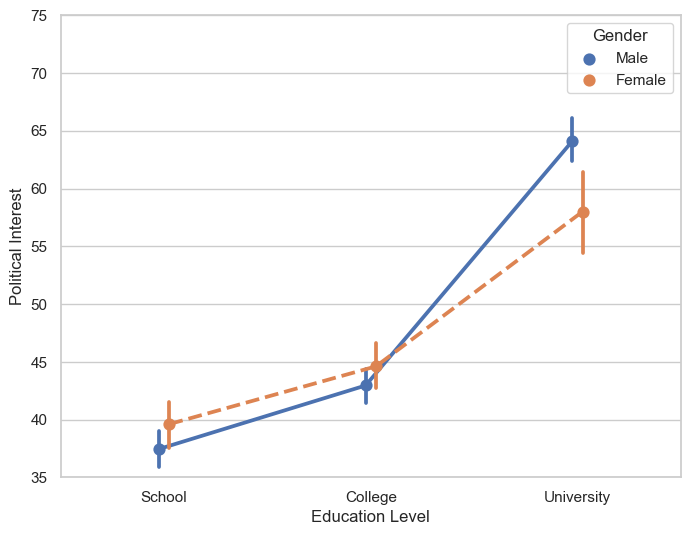

In [124]:
plt.figure(figsize=(8, 6))
sns.pointplot(x='Education_Level', y='Political_Interest', hue='Gender', data=df, dodge=True, markers=['o', 'o'], linestyles=['-', '--'])
plt.ylim(35, 75)
plt.xlabel("Education Level")
plt.ylabel("Political Interest")
plt.legend(title='Gender')
plt.show()

**Remark:** A simple main effects analysis was performed to explore the influence of gender across different levels of education. At the university level, the analysis revealed a statistically significant effect of gender, F(1,18)=7.266, 𝑝<0.025. This finding suggests a notable difference in political interest between males and females within the university education group.

### Simple Main Effects - education_level

In [125]:
results = {}

alpha_adjusted = 0.025

for gender in df['Gender'].unique():
    df_gender = df[df['Gender'] == gender]
    
    model = ols('Political_Interest ~ C(Education_Level)', data=df_gender).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    F_value = anova_table.loc['C(Education_Level)', 'F']
    p_value = anova_table.loc['C(Education_Level)', 'PR(>F)']
    
    significant = p_value < alpha_adjusted
    
    results[gender] = {'Sum of Squares': anova_table.loc['C(Education_Level)', 'sum_sq'],
                       'df': int(anova_table.loc['C(Education_Level)', 'df']),
                       'Mean Square': anova_table.loc['C(Education_Level)', 'sum_sq'] / anova_table.loc['C(Education_Level)', 'df'],
                       'F': F_value,
                       'p': p_value,
                       'Significant': significant}

results_df = pd.DataFrame(results).T
title_simpgen = '<h4 style="text-align: left;">Simple Main Effects - Education Level</h4>'
display(HTML(title_simpgen))
results_df

,Sum of Squares,df,Mean Square,F,p,Significant
Male,3809.897,2,1904.948,266.286,0.000,True
Female,1810.400,2,905.200,42.968,0.000,True


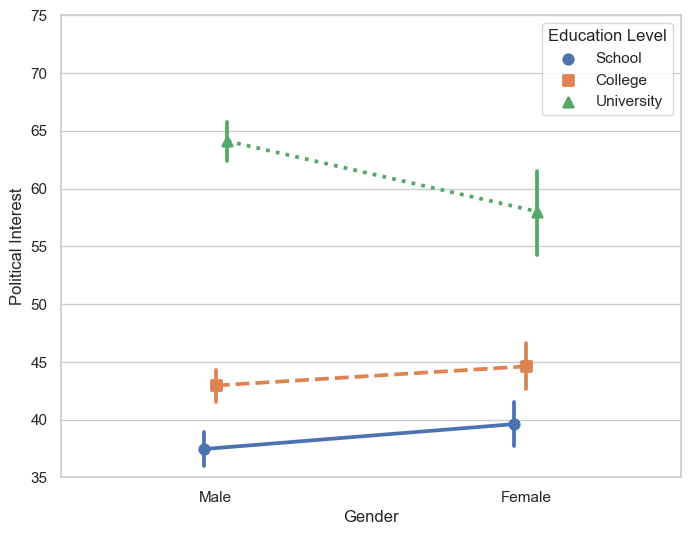

In [128]:
plt.figure(figsize=(8, 6))

education_levels = df['Education_Level'].unique()
markers = ['o', 's', '^'][:len(education_levels)]
linestyles = ['-', '--', ':'][:len(education_levels)]

sns.pointplot(x='Gender', y='Political_Interest', hue='Education_Level', data=df, dodge=True, 
              markers=markers, linestyles=linestyles)

plt.ylim(35, 75)
plt.xlabel("Gender")
plt.ylabel("Political Interest")
plt.legend(title='Education Level')
plt.show()

**Remark:** A simple main effects analysis was conducted to assess the impact of education level within each gender. For males, the effect of education level was statistically significant, F(2,25)=132.493,p<.001, indicating a notable difference in political interest across various education levels. Similarly, for females, the education level also had a statistically significant effect, F(2,25)=62.958,p<.001, suggesting significant differences in political interest across education levels for females as well.

## Post Hoc Comparisons – Gender*Educational Level

In [86]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df['Group'] = df['Education_Level'] + ' - ' + df['Gender']

tukey = pairwise_tukeyhsd(endog=df['Political_Interest'], groups=df['Group'], alpha=0.05)
tukey_results = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

tukey_results['SE'] = np.sqrt((tukey_results['meandiff'] ** 2) / len(df))
tukey_results['t'] = tukey_results['meandiff'] / tukey_results['SE']

tukey_results.rename(columns={
    'group1': 'Group 1',
    'group2': 'Group 2',
    'meandiff': 'Mean Difference',
    'lower': 'Lower CI',
    'upper': 'Upper CI',
    'p-adj': 'p_tukey'
}, inplace=True)

tukey_results = tukey_results[['Group 1', 'Group 2', 'Mean Difference', 'Lower CI', 'Upper CI', 'SE', 't', 'p_tukey']]

title_posthoc = '<h4 style="text-align: left;">Post Hoc Comparisons - Education Level and Gender</h4>'
title_ci = '<h5 style="text-align: left;">95% CI for Mean Difference</h5>'

display(HTML(title_posthoc))
display(HTML(title_ci))
display(tukey_results.style.hide(axis="index"))

Group 1,Group 2,Mean Difference,Lower CI,Upper CI,SE,t,p_tukey
College - Female,College - Male,-1.655600,-6.810100,3.499000,0.217391,-7.615773,0.931200
College - Female,School - Female,-5.000000,-10.017000,0.017000,0.656532,-7.615773,0.051300
College - Female,School - Male,-7.155600,-12.310100,-2.001000,0.939576,-7.615773,0.001900
College - Female,University - Female,13.400000,8.383000,18.417000,1.759506,7.615773,0.000000
College - Female,University - Male,19.500000,14.483000,24.517000,2.560475,7.615773,0.000000
College - Male,School - Female,-3.344400,-8.499000,1.810100,0.439141,-7.615773,0.402100
College - Male,School - Male,-5.500000,-10.788400,-0.211600,0.722185,-7.615773,0.037100
College - Male,University - Female,15.055600,9.901000,20.210100,1.976897,7.615773,0.000000
College - Male,University - Male,21.155600,16.001000,26.310100,2.777866,7.615773,0.000000
School - Female,School - Male,-2.155600,-7.310100,2.999000,0.283044,-7.615773,0.816500


In [69]:
describe_stats = []

for group_name, group_data in df.groupby(['Education_Level', 'Gender']):
    political_interest = group_data['Political_Interest']
    
    mean = political_interest.mean()
    std_dev = political_interest.std()
    count = political_interest.count()
    se = std_dev / np.sqrt(count)
    cv = (std_dev / mean)
    
    describe_stats.append({
        'Gender - Educational Level': f"{group_name[1]} - {group_name[0]}",
        'N': count,
        'Mean': mean,
        'SD': std_dev,
        'SE': se,
        'Coefficient of Variation': cv,
    })

describe_table = pd.DataFrame(describe_stats).set_index('Gender - Educational Level')

describe_table = describe_table.style.format({
    'Mean': '{:.3f}',
    'SD': '{:.3f}',
    'SED': '{:.3f}',
    'Coefficient of Variation': '{:.3f}',
})

title_describe = '<h4 style="text-align: left;">Descriptives - Political Interest</h4>'
display(HTML(title_describe))
display(describe_table)

,N,Mean,SD,SE,Coefficient of Variation
Gender - Educational Level,,,,,
Female - College,10,44.600,3.273,1.034945,0.073
Male - College,9,42.944,2.338,0.779264,0.054
Female - School,10,39.600,3.273,1.034945,0.083
Male - School,9,37.444,2.506,0.835183,0.067
Female - University,10,58.000,6.464,2.043961,0.111
Male - University,10,64.100,3.071,0.971253,0.048


**Remark:** Pairwise comparisons were conducted for each simple main effect, with Tukey-adjusted p-values and 95% confidence intervals reported. Scores are to be presented as mean ± standard deviation. For females, the mean "Political Interest" scores were 39.600 ± 3.273 for school-educated, 44.600 ± 3.273 for college-educated, and 58.000 ± 6.464 for university-educated. School-educated females had a significantly lower mean "Political Interest" score compared to university-educated females, with a difference of 18.40 (95% CI, 13.383 to 23.417), p < .0005. Similarly, college-educated females had a significantly lower score than university-educated females, with a difference of 13.400 (95% CI, 8.383 to 18.417), p < .0005.

For males, the mean "Political Interest" scores were 37.444 ± 2.506 for school-educated, 42.944 ± 2.338 for college-educated, and 64.100 ± 3.071 for university-educated. School-educated males had significantly lower mean "Political Interest" scores compared to college-educated males, with a difference of 5.500 (95% CI, 0.212 to 10.788), p = .037, and university-educated males, with a difference of 26.656 (95% CI, 21.501 to 31.810), p < .0005. College-educated males also had a significantly lower score compared to university-educated males, with a difference of 21.156 (95% CI, 16.001 to 26.310), p < .0005.